# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

*La métrica RECM en el conjunto de prueba no debe ser superior a 48.*

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [31]:
#Carga de libreías necesarias para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#Librería para las tendencias y estacionalidad
from statsmodels.tsa.seasonal import seasonal_decompose

#Librerías o modulos de scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [32]:
#Carga de datos y visualización de los mismos
data = pd.read_csv('taxi.csv')
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [33]:
#Información general de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


En primera instancia podemos observar que se trata de un dataset que contiene 26,496 filas, 2 columnas y ningun tipo de valor nulo en las mismas. 

Sin embargo, para propósitos del proyectos, es conveniente realizar un cambio de tipo de dato a la columna `datetime` al tipo ``datetime64`` para que este posteriormente forme parte del índice de nuestra tabla o dataset.

In [34]:
#Cambio de tipo de dato a la columna datetime y visualicemos los cambios
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Ahora vamos establecer, como habiamos comentado anteriormente, la columna `datetime` como índice

In [35]:
#Asignación de la columna datetime como índice
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates= [0])

Una vez más, veamos cómo se visualiza este dataset con este cambio.

In [36]:
#Información general nueva
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [37]:
#Cabecera de los datos
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Vamos a asegurarnos que nuestras fechas que ahora están acotadas como índice en nuestro dataset tengan un orden coherente, para esto, utilizaremos el atributo ``is_monotonic_increasing`` para asegurarnos que así sea y no tengamos incovenientes en el orden de fechas. Este atributo nos da un _output_ booleano, es decir, _True_ si los datos están en orden o _False_ si es lo contrario.

In [38]:
#Asegurar orden de fechas
print(data.index.is_monotonic_increasing)

True


Nuestro ``DatetimeIndex`` ya nos mostraba este dato, pero es mejor asegurarnos y no dejar desapercibido este dato.

Por lo que sabemos, también tenemos un rango de fechas de **Marzo - 2018 - 01 a Agosto - 2018 - 31.**

Veámos cómo se ve nuestro dataset si lo graficamos a grandes rasgos.

<Axes: xlabel='datetime'>

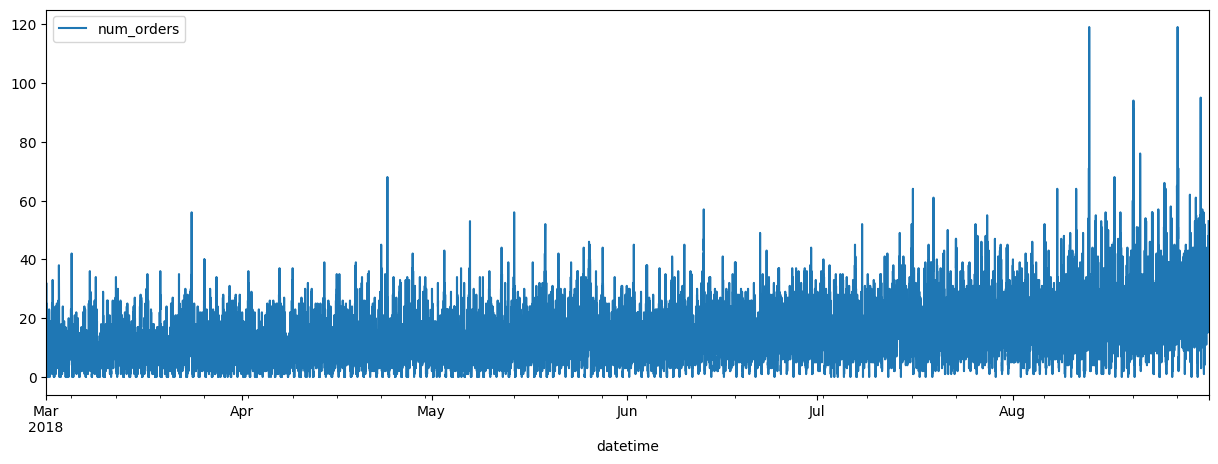

In [39]:
#Gráfico
data.plot(figsize=(15,5))

Por parte de los datos sabemos que se tiene registro gráfico cada **10 minutos**, pero se requiere el análisis de los datos **cada hora**, por lo que es conveniente realizar un _Remuestreo de nuestros datos_.

## Procesamiento y análisis de datos

### Remuestreo

Cambiemos los valores de la serie con el remuestreo, nuestra tarea en este caso será cambiar este intervalo de tiempo para una hora, para que tengamos una _ventana_ más amplía.

C:\Users\Ariel\AppData\Local\Temp\ipykernel_21260\2972029000.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resample = data.resample('1H').median()


,num_orders
datetime,
2018-03-01 00:00:00,20.5
2018-03-01 01:00:00,14.5
2018-03-01 02:00:00,10.0
2018-03-01 03:00:00,9.0
2018-03-01 04:00:00,4.0
...,...
2018-08-31 19:00:00,23.5
2018-08-31 20:00:00,26.0
2018-08-31 21:00:00,27.0


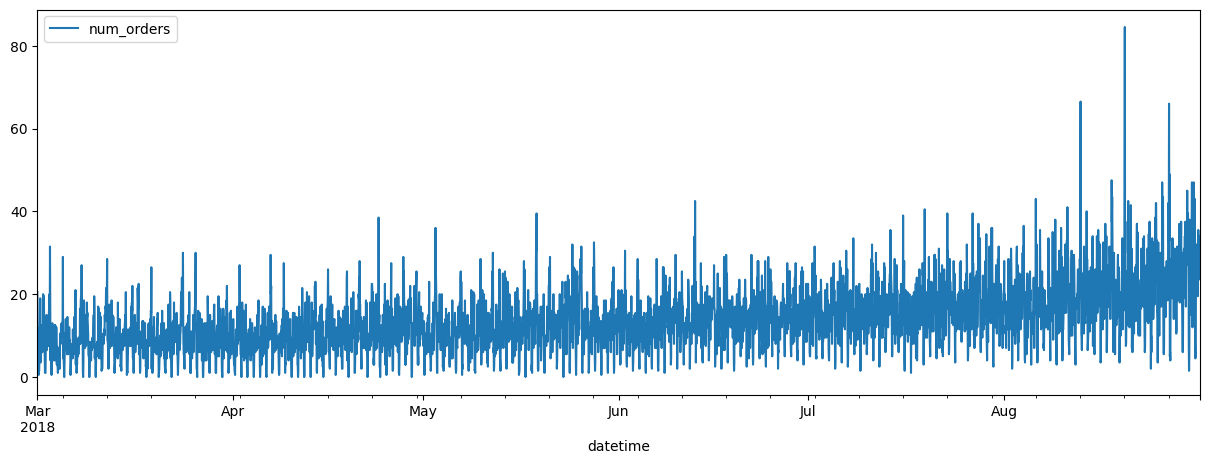

In [40]:
#Remuestreo
data_resample = data.resample('1H').median()
data_resample.plot(figsize=(15,5))
data_resample

Utilizo la mediana ya que así el impacto de valores atípicos se suaviza con el remuestreo. Además de nuestro rango de visualización de datos ha pasado de 10 minutos a 1 hora.

### Media móvil

La media móvil nos ayudará en las fluctuaciones de nuestra Serie Temporal, tal y como hemos vismo en nuestro gráfico.

Además de lo anterior también nos ayudará a identificar _tendencias e identificar patrones_.

Véamos cómo podemos implementar esta media móvil o promedio móvil.

In [41]:
#Implementación de la media móvil y desfase para la característica
data_resample['rolling_mean'] = data_resample['num_orders'].shift().rolling(24).mean()

Asignamos una ventana de 24, contemplando que el día contiene un total de 24 horas en un día, además de que fue la forma en la que también fue el objetivo de haber asignado remuestreo en una hora.

In [42]:
#Veamos cómo quedó
data_resample.sample(5)

,num_orders,rolling_mean
datetime,,
2018-06-10 14:00:00,16.5,14.520833
2018-04-26 16:00:00,19.0,11.020833
2018-03-29 19:00:00,8.5,9.520833
2018-07-31 07:00:00,8.0,17.916667
2018-07-07 08:00:00,13.5,17.000000


<Axes: xlabel='datetime'>

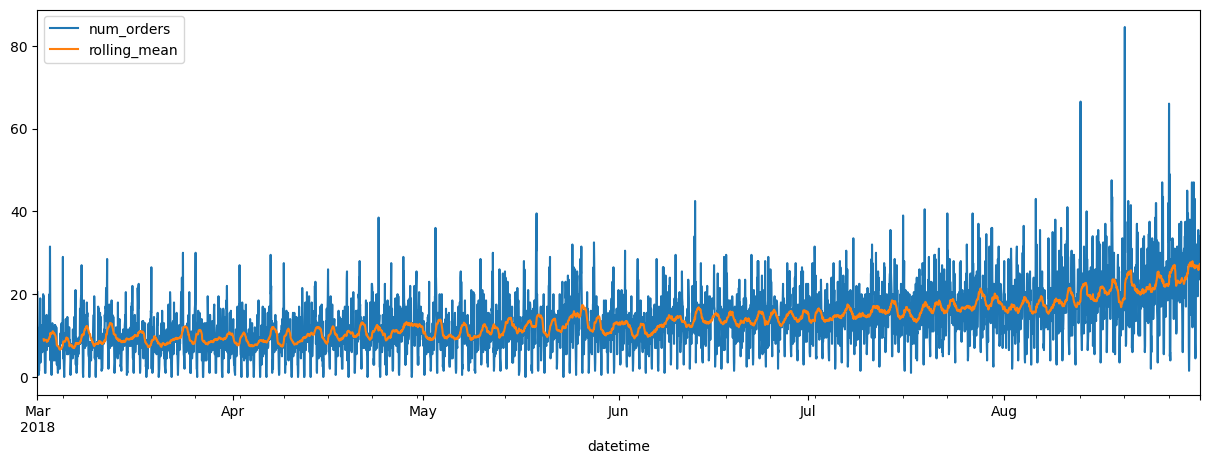

In [43]:
#Veámos cómo quedó graficamente
data_resample.plot(figsize=(15,5))

### Tendencia, estacionalidad y residuos

Ahora revisaremos los gráficos correspondientes a la tendencia, estacionalidad y residuos.

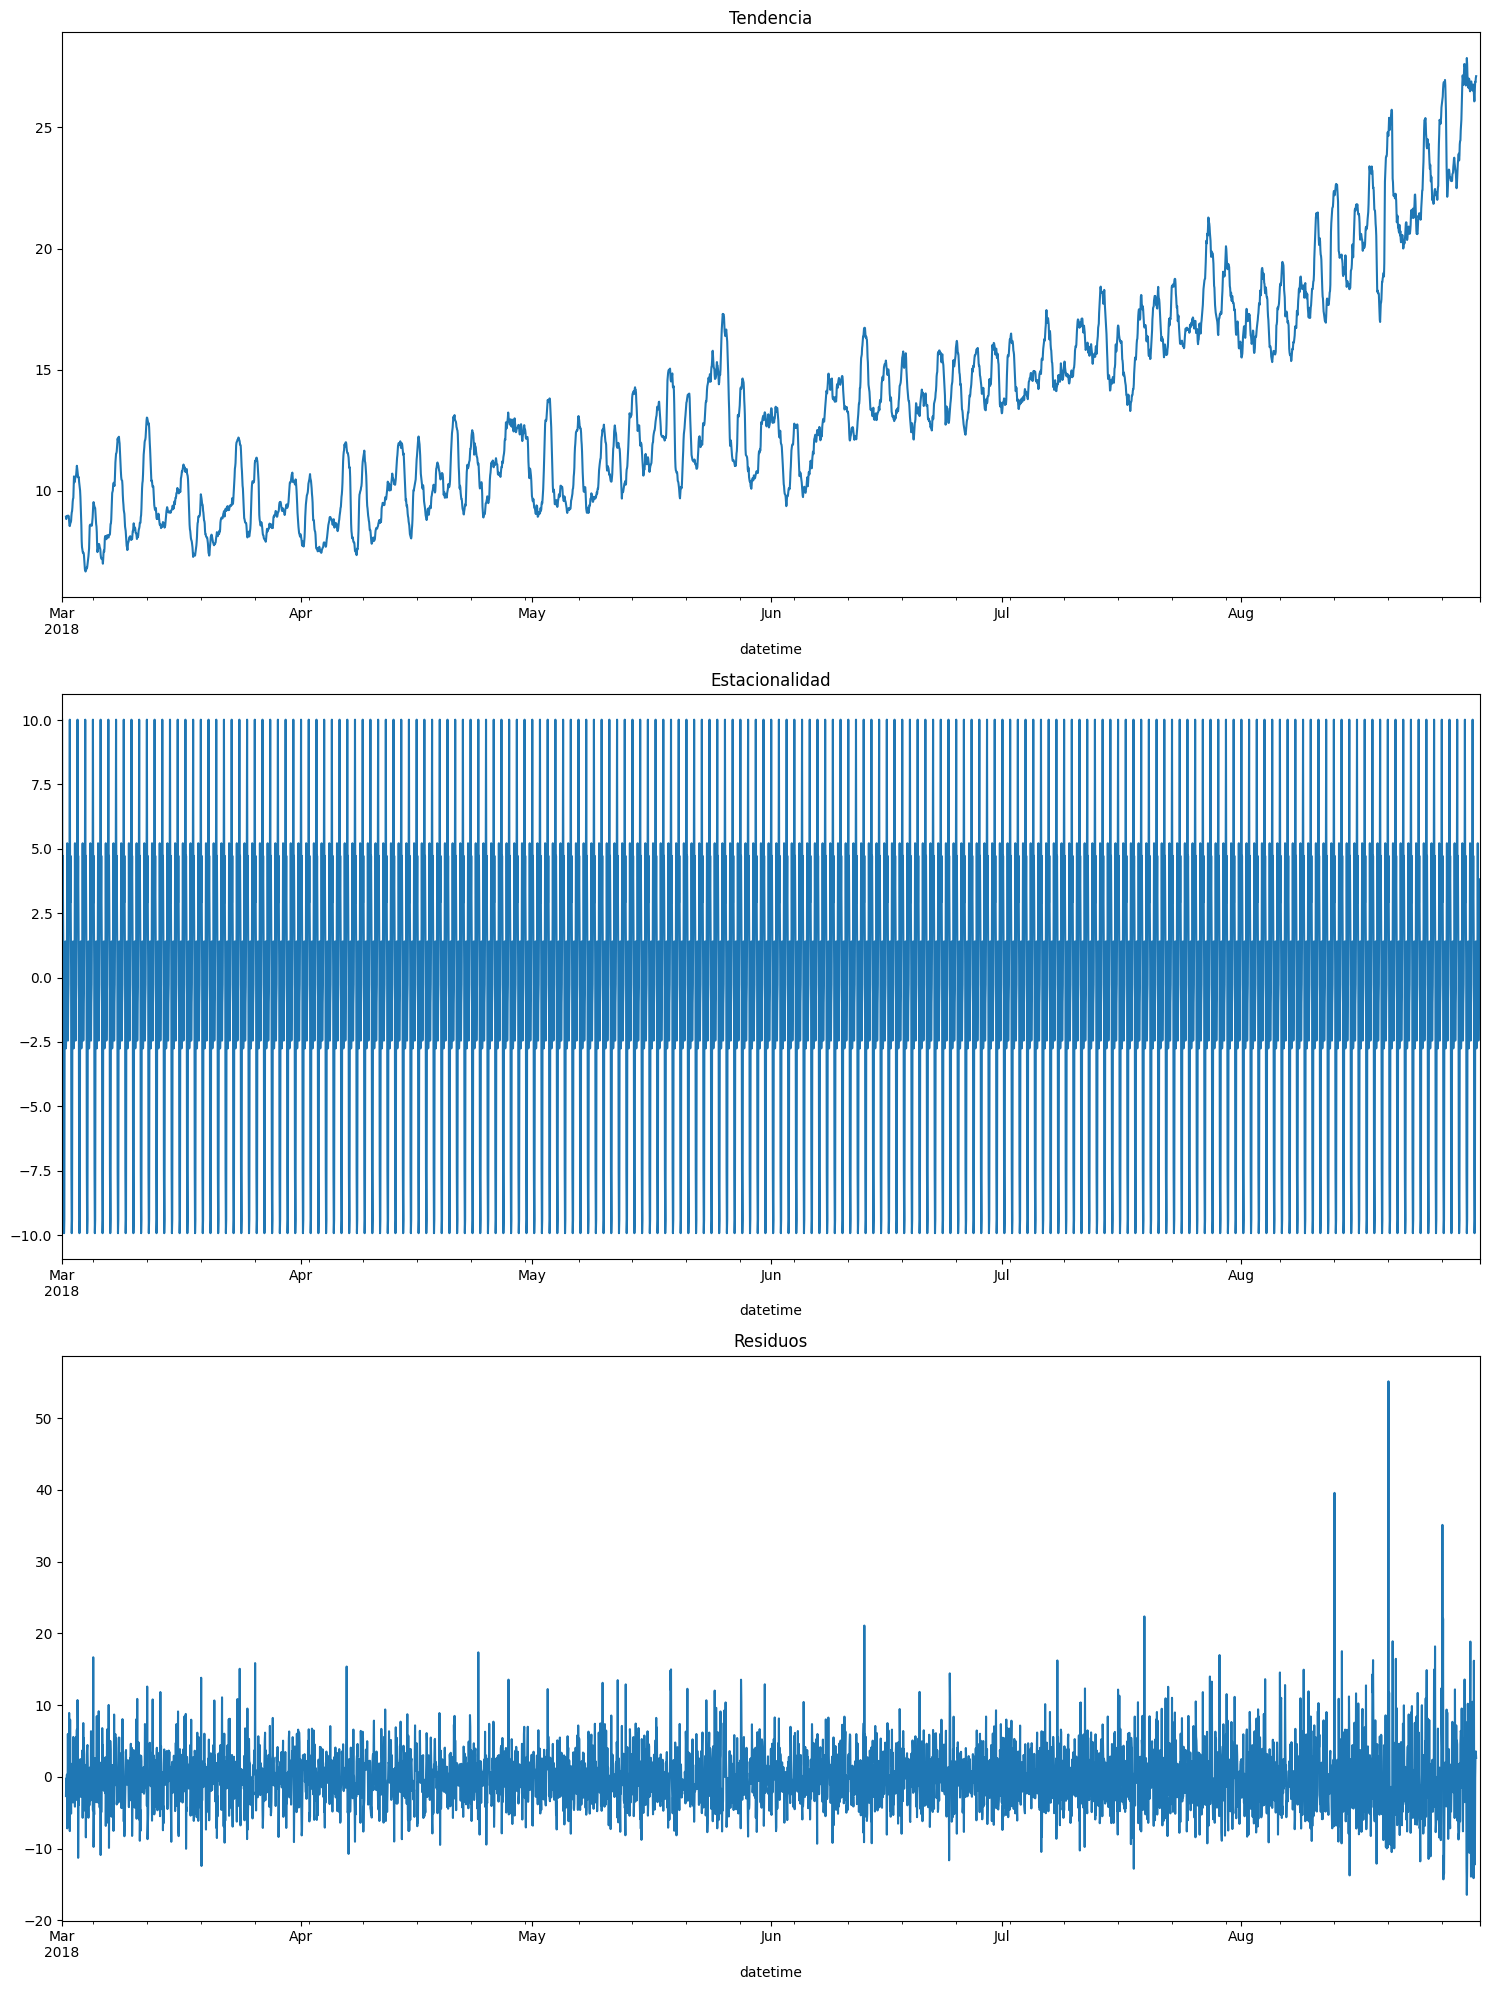

In [44]:
decomposed_data = seasonal_decompose(data_resample['num_orders'])

plt.figure(figsize=(15,20))
plt.subplot(311) #-----> 3 filas, 1 columna, 1er gráfico, el último índice es el número de gráfico
decomposed_data.trend.plot(ax=plt.gca()) #----> gca = get current axis
plt.title('Tendencia')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuos')
plt.tight_layout()

La interpretación individual de cada gráfico, indica los siguiente:

- La tendencia índica que, conforme los meses pasan, los viajes aumentan. Este aumento es gradual.

- La estacionalidad del gráfico 2, este tiene oscilaciones de -10 a 10 y vemos que esto es constante, por lo que podemos decir que esta gráfica es estacionaria y la distribución no varía respecto al tiempo.

- Los residuos, tal y como sabemos de forma teórica, no tiene explicación intrínseca por parte de la tendencia y estacionalidad. Sin embargo, vemos algunos cambios significativos en lo que vendría siendo el último mes registrado en el dataset, agosto.

C:\Users\Ariel\AppData\Local\Temp\ipykernel_21260\2618388950.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_resample.resample('M').mean().plot(figsize=(15,5))


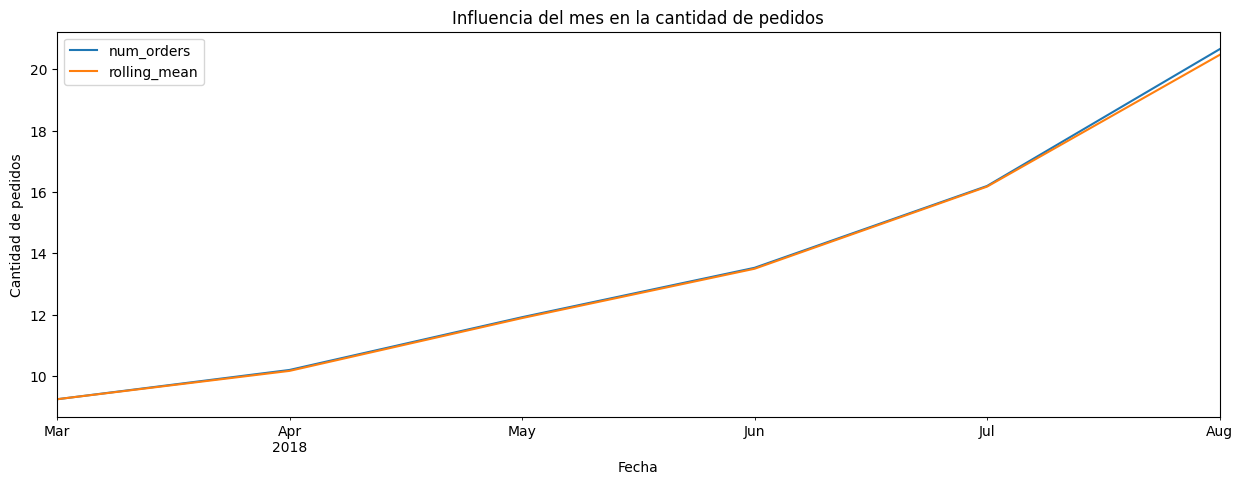

In [45]:
#Influencia del mes en la cantidad de pedidos
data_resample.resample('M').mean().plot(figsize=(15,5))
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pedidos')
plt.title('Influencia del mes en la cantidad de pedidos')
plt.show()

Tal y como se puede apreciar en la tendencia, los pedidos aumentan gradualmente de Marzo a Agosto de forma lineal.

## Análisis y Creación de Características

Vamos a crear las características que nos permitan _ayudar_ al entrenamiento de los modelos que vayamos a probar en este proyecto. El flujo de trabajo consta de la siguiente manera:

- Creación de características de calendario: Crear las características que contengan valores como el año, mes, día, día de la semana y hora.

- Características de desfase: Aquí usaremos la función ``shift()`` para crear nuestras características de desfase.

- Característica de la media móvil: Para poder visualizar la tendencia general de nuestra Serie Temporal, que ya tenemos delimitada.

### Características de calendario

In [46]:
#Vamos a acotar estas características como mencionamos
data_resample['year'] = data_resample.index.year
data_resample['month'] = data_resample.index.month
data_resample['day'] = data_resample.index.day  
data_resample['day_of_week'] = data_resample.index.dayofweek
data_resample['hour'] = data_resample.index.hour

### Características de desfase (``shift``)

In [47]:
#Declaración de cuántos pasos adelante queremos predecir
max_lag = 7

#Bucle para las características
for lag in range(1, max_lag + 1):
    data_resample['lag_{}'.format(lag)] = data_resample['num_orders'].shift(lag)

data_resample.head()

,num_orders,rolling_mean,year,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,20.5,NaN,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,14.5,NaN,2018,3,1,3,1,20.5,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,10.0,NaN,2018,3,1,3,2,14.5,20.5,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,9.0,NaN,2018,3,1,3,3,10.0,14.5,20.5,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,4.0,NaN,2018,3,1,3,4,9.0,10.0,14.5,20.5,NaN,NaN,NaN


# División de datos en entrenamiento y prueba

Vamos a realizar la división de datos respecto a nuestro dataframe con las columnas o características que hemos realizado en el paso previo.

In [48]:
#División de datos en entrenamiento y prueba
train, test = train_test_split(data_resample, test_size = 0.1, shuffle = False) #---> Existe la condición de test_size = 0.1
#Del conjunto de entrenamiento borramos valores nulos
train = train.dropna()

In [49]:
#Creación de varibles en conjunto de objetivo y características
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

Veamos si hay una correcta división de datos.

In [50]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Vemos que se ha particionado de buena forma, dando apertura de una hora de diferencia entre el conjunto o las fechas de entrenamiento y prueba.

## Prueba o Entrenamiento de los modelos 

Antes de seguir con el entrenamiento, lo mejor sería tener un valor de referencia o una constante para realizar una comparación con nuestros modelos de predicción.

In [51]:
#Constante predictiva
print(f'Mediana de los pedidos de taxi por hora:', test['num_orders'].median())

Mediana de los pedidos de taxi por hora: 21.5


Si bien es cierto que tenemos una referencia en no sobrepasar nuestro _RECM_ de 48, también es conveniente tener una constante a manera de evaluación.

Ahora vamos con el entrenamiento de regresión propuestos, los cuales son los siguientes:

- Regresión Lineal
- Árbol de Decisión de Regresión
- Bosque Aleatorio de Regresión

Evaluaremos estos tres modelos ayudando con GridSearchCV para mejorar los hiperparámetros de cada modelo propuesto.

## Regresión Lineal

In [59]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [88]:
#Predicciones del modelo lineal
predictions_lr_test = model_lr.predict(features_test)
predictions_lr_train = model_lr.predict(features_train)

#Métrica 
recm_lr_train = root_mean_squared_error(target_train, predictions_lr_train)
recm_lr_test =root_mean_squared_error(target_test, predictions_lr_test)
#Métrica RECM (raíz del error cuadrático medio)
print(f'RECM en el conjunto de entrenamiento:', round(recm_lr_train,2))
print(f'RECM en el conjunto de prueba:', round(recm_lr_test,2))

RECM en el conjunto de entrenamiento: 5.36
RECM en el conjunto de prueba: 8.92


## Árbol de Decisión de Regresión

Aquí haremos uso de la herramiento GridSearchCV para poder oprimizar nuestros hiperparámetros de los modelos restantes para evaluar nuestrp RECM.

In [61]:
#GridSearchCV para el árbol de decisión
param_grid = {'max_depth':[2, 4, 6, 8, 10]}
#Definición del modelo
model_dr = DecisionTreeRegressor(random_state = 12345)
grid_dr = GridSearchCV(estimator = model_dr, param_grid = param_grid, cv = 3, verbose = True)
grid_dr.fit(features_train, target_train)
grid_dr.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'max_depth': 4}

Aplicación del hiperparámetro en el modelo de Árbol de Decisión de Regresión

In [63]:
#Modelo DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(max_depth = 4, random_state = 12345)
model_dtr.fit(features_train, target_train)
predic_dtr_train = model_dtr.predict(features_train)
predict_dtr_test = model_dtr.predict(features_test)

In [64]:
#Métricas RECM
recm_train_dtr = root_mean_squared_error(target_train, predic_dtr_train)
recm_test_dtr = root_mean_squared_error(target_test, predict_dtr_test)

In [75]:
print(f'RECM en el conjunto de entrenamiento para el modelo DecisionTreeRegressor:', round(recm_train_dtr,2))
print(f'RECM en el conjunto de prueba para el modelo DecisionTreeRegressor:', round(recm_test_dtr,2))

RECM en el conjunto de entrenamiento para el modelo DecisionTreeRegressor: 4.68
RECM en el conjunto de prueba para el modelo DecisionTreeRegressor: 10.25


## Bosque Aleatorio de Regresión

Seguiremos la misma metodología, para que al final, podamos armar un dataframe con la información conjunta de los valores de la métrica RECM tanto para el conjunto de entrenamiento (_train_) como para el de prueba (_test_).

In [77]:
#GridSearchCV para el bosque aleatorio
param_grid = {'max_depth':[2, 4, 6, 8, 10]}
#Definición del modelo
model_rf = RandomForestRegressor(random_state = 12345)
grid_rf = GridSearchCV(estimator = model_rf, param_grid = param_grid)
grid_rf.fit(features_train, target_train)
grid_rf.best_params_

{'max_depth': 10}

De acuerdo a la documentación del bosque aleatorio, se tiene que ``n_estimators`` tiene el valor por default de 100, por lo que lo omitimos en GridSearch.

Posiblemente el hecho de añadirlo podría tener mayor tiempo computacional del requerido para esta tarea.

In [78]:
#Modelo RandomForestRegressor
model_rfg = RandomForestRegressor(random_state = 12345)
model_rfg.fit(features_train, target_train)
predic_rfg_train = model_rfg.predict(features_train)
predict_rfg_test = model_rfg.predict(features_test)

In [80]:
#Métricas RECM
recm_train_rfg = root_mean_squared_error(target_train, predic_rfg_train)
recm_test_rgf = root_mean_squared_error(target_test, predict_rfg_test)

In [82]:
print(f'RECM en el conjunto de entrenamiento para el modelo RandomForestRegressor:', round(recm_train_rfg,2))
print(f'RECM en el conjunto de prueba para el modelo RandomForestRegressor:', round(recm_test_rgf,2))

RECM en el conjunto de entrenamiento para el modelo RandomForestRegressor: 1.52
RECM en el conjunto de prueba para el modelo RandomForestRegressor: 7.44


## Creación de DataFrame con las métricas de cada modelo

In [89]:
#Creación del dataframe
df_metrics = pd.DataFrame({'Modelo': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor'],
                   'RECM en el conjunto de entrenamiento': [recm_lr_train, recm_train_dtr, recm_train_rfg],
                   'RECM en el conjunto de prueba': [recm_lr_test, recm_test_dtr, recm_test_rgf]})
df_metrics

,Modelo,RECM en el conjunto de entrenamiento,RECM en el conjunto de prueba
0,Linear Regression,5.358419,8.923827
1,Decision Tree Regressor,4.675833,10.247914
2,Random Forest Regressor,1.522772,7.443653


# Conclusiones

Realmente los modelos tuvieron y se ajustaron muy bien a las necesidades principales del proyecto gracias a la herramienta GridSearchCV. 

Los modelos propuestos realmente tuvieron un valor de la métrica por debajo de los esperado (47), sin embargo, el rendimiento en cada uno es diferente, por lo que se puede clasificar de la siguiente manera con los tres modelos:

- RandomForestRegressor
- Linear Regression
- Decision Tree Regressor

La clasificación está úbicada principalmente por el RECM obtenido en el conjunto de prueba.